<a href="https://colab.research.google.com/github/nanpolend/machine-learning/blob/master/BTC%E7%9A%84%E6%9C%88%E7%B7%9A%E5%91%A8%E6%9C%9F%E5%BE%AA%E7%92%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33287 (\N{CJK UNIFIED IDEOGRAPH-8207}) missing from font(s) DejaVu Sans.
  fig.canvas

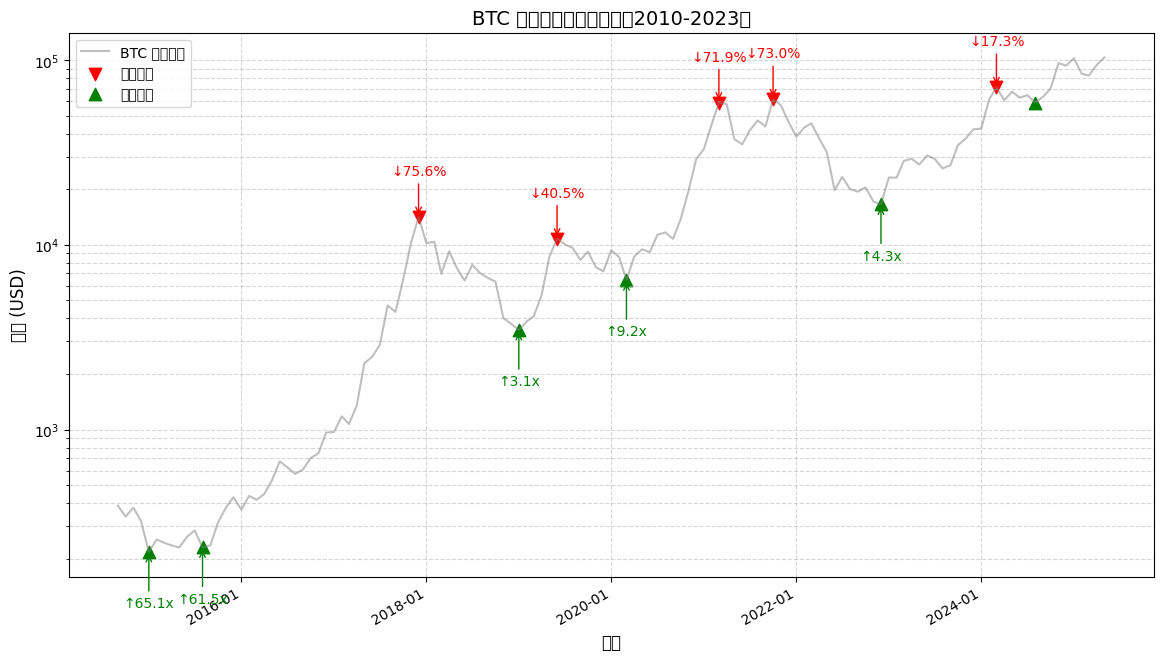

,高點時間,低點時間,高點價格,低點價格,跌幅(%)
0,2017-12,2019-01,"14,156","3,458",75.6%
1,2019-06,2020-03,"10,817","6,439",40.5%
2,2021-03,2022-12,"58,919","16,548",71.9%
3,2021-10,2022-12,"61,319","16,548",73.0%
4,2024-03,2024-08,"71,334","58,970",17.3%


,低點時間,高點時間,低點價格,高點價格,漲幅(倍)
0,2015-01,2017-12,217,"14,156",65.1x
1,2015-08,2017-12,230,"14,156",61.5x
2,2019-01,2019-06,"3,458","10,817",3.1x
3,2020-03,2021-03,"6,439","58,919",9.2x
4,2022-12,2024-03,"16,548","71,334",4.3x


In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 解決中文顯示問題（Mac）
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# --------------------
# 1. 從 Yahoo Finance 抓取 BTC 月線資料
# --------------------
def fetch_btc_monthly_data():
    btc = yf.Ticker("BTC-USD")
    df = btc.history(period="max", interval="1mo")  # 獲取所有歷史月線數據
    df = df[['Close']].reset_index()  # 只保留收盤價和日期
    df.columns = ['timestamp', 'price']  # 重命名列
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.dropna()

df = fetch_btc_monthly_data()

# --------------------
# 2. 識別局部高點和低點
# --------------------
window = 6  # 識別高低點的窗口大小（單位：月）

# 找局部高點
high_idx = argrelextrema(df['price'].values, np.greater, order=window)[0]
highs = df.iloc[high_idx]

# 找局部低點
low_idx = argrelextrema(df['price'].values, np.less, order=window)[0]
lows = df.iloc[low_idx]

# --------------------
# 3. 計算漲跌週期與幅度
# --------------------
def calculate_cycles(highs, lows):
    # 跌勢週期：高點 → 後續低點
    bear_cycles = []
    for i in range(len(highs)):
        subsequent_lows = lows[lows['timestamp'] > highs.iloc[i]['timestamp']]
        if not subsequent_lows.empty:
            low = subsequent_lows.iloc[0]
            drawdown = (highs.iloc[i]['price'] - low['price']) / highs.iloc[i]['price'] * 100
            bear_cycles.append({
                '高點時間': highs.iloc[i]['timestamp'].strftime('%Y-%m'),
                '低點時間': low['timestamp'].strftime('%Y-%m'),
                '高點價格': round(highs.iloc[i]['price'], 2),
                '低點價格': round(low['price'], 2),
                '跌幅(%)': round(drawdown, 1)
            })

    # 漲勢週期：低點 → 後續高點
    bull_cycles = []
    for i in range(len(lows)):
        subsequent_highs = highs[highs['timestamp'] > lows.iloc[i]['timestamp']]
        if not subsequent_highs.empty:
            high = subsequent_highs.iloc[0]
            multiplier = high['price'] / lows.iloc[i]['price']
            bull_cycles.append({
                '低點時間': lows.iloc[i]['timestamp'].strftime('%Y-%m'),
                '高點時間': high['timestamp'].strftime('%Y-%m'),
                '低點價格': round(lows.iloc[i]['price'], 2),
                '高點價格': round(high['price'], 2),
                '漲幅(倍)': round(multiplier, 1)
            })

    return pd.DataFrame(bear_cycles), pd.DataFrame(bull_cycles)

bear_df, bull_df = calculate_cycles(highs, lows)

# --------------------
# 4. 繪製價格走勢圖與週期標註（修正 SyntaxError）
# --------------------
def plot_btc_cycles(df, highs, lows):
    plt.figure(figsize=(14, 8))

    # 繪製價格曲線
    plt.plot(df['timestamp'], df['price'], label='BTC 月收盤價', color='gray', alpha=0.5)

    # 標註高點
    plt.scatter(highs['timestamp'], highs['price'], color='red', marker='v', s=80, label='局部高點')
    # 標註低點
    plt.scatter(lows['timestamp'], lows['price'], color='green', marker='^', s=80, label='局部低點')

    # 標註跌勢週期
    for _, row in bear_df.iterrows():
        plt.annotate(
            f"↓{row['跌幅(%)']}%",
            xy=(pd.to_datetime(row['高點時間']), row['高點價格']),  # 修正：明確指定 xy 座標
            xytext=(0, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='red'),
            color='red',
            ha='center'
        )

    # 標註漲勢週期
    for _, row in bull_df.iterrows():
        plt.annotate(
            f"↑{row['漲幅(倍)']}x",
            xy=(pd.to_datetime(row['低點時間']), row['低點價格']),  # 修正：明確指定 xy 座標
            xytext=(0, -40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='green'),
            color='green',
            ha='center'
        )

    # 設置圖表格式
    plt.title('BTC 月線價格與漲跌週期（2010-2023）', fontsize=14)
    plt.xlabel('時間', fontsize=12)
    plt.ylabel('價格 (USD)', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.show()

plot_btc_cycles(df, highs, lows)

# --------------------
# 5. 輸出統計表格（高亮最大漲跌幅）
# --------------------
def highlight_max(s, props=''):
    return np.where(s == s.max(), props, '')

# 跌勢週期表格
display(bear_df.style
        .format({'高點價格': '{:,.0f}', '低點價格': '{:,.0f}', '跌幅(%)': '{:.1f}%'})
        .apply(highlight_max, props='color:white; background-color:#FF6B6B', axis=0)
        .set_caption('跌勢週期統計'))

# 漲勢週期表格
display(bull_df.style
        .format({'低點價格': '{:,.0f}', '高點價格': '{:,.0f}', '漲幅(倍)': '{:.1f}x'})
        .apply(highlight_max, props='color:white; background-color:#66BB6A', axis=0)
        .set_caption('漲勢週期統計'))